In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.vision import *
import torch

%matplotlib inline

In [2]:
! tree -d ..

..
├── data
│   ├── axial
│   │   ├── train
│   │   └── valid
│   ├── coronal
│   │   ├── train
│   │   └── valid
│   └── sagittal
│       ├── models
│       ├── train
│       └── valid
└── mrnet-fastai

12 directories


In [3]:
! ls ../data

axial	  train-abnormal.csv  valid-abnormal.csv
coronal   train-acl.csv       valid-acl.csv
sagittal  train-meniscus.csv  valid-meniscus.csv


In [4]:
data_path = Path('../data')
sag_path = data_path/'sagittal'
cor_path = data_path/'coronal'
ax_path = data_path/'axial'

In [5]:
train_abnl = pd.read_csv(data_path/'train-abnormal.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})
print(train_abnl.shape)
train_abnl.head()

(1130, 2)


,Case,Abnormal
0,0000,1
1,0001,1
2,0002,1
3,0003,1
4,0004,1


In [6]:
w = train_abnl.Abnormal.sum() / train_abnl.shape[0]
print(w)
weights = Tensor([w, 1-w])
print(weights)

0.8079646017699115
tensor([0.8080, 0.1920])


In [7]:
valid_abnl = pd.read_csv(data_path/'valid-abnormal.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})
print(valid_abnl.shape)
valid_abnl.head()

(120, 2)


,Case,Abnormal
0,1130,0
1,1131,0
2,1132,0
3,1133,0
4,1134,0


In [8]:
train_abnl['Case'] = train_abnl.Case.apply(lambda x: 'train/{}'.format(x))
train_abnl['is_valid'] = 0
train_abnl.head()

,Case,Abnormal,is_valid
0,train/0000,1,0
1,train/0001,1,0
2,train/0002,1,0
3,train/0003,1,0
4,train/0004,1,0


In [9]:
valid_abnl['Case'] = valid_abnl.Case.apply(lambda x: 'valid/{}'.format(x))
valid_abnl['is_valid'] = 1
valid_abnl.head()

,Case,Abnormal,is_valid
0,valid/1130,0,1
1,valid/1131,0,1
2,valid/1132,0,1
3,valid/1133,0,1
4,valid/1134,0,1


In [10]:
df_abnl = pd.concat([train_abnl, valid_abnl])
print(df_abnl.shape)
df_abnl.head()

(1250, 3)


,Case,Abnormal,is_valid
0,train/0000,1,0
1,train/0001,1,0
2,train/0002,1,0
3,train/0003,1,0
4,train/0004,1,0


In [12]:
def load_one_stack(case, data_path=data_path, plane='coronal'):
    fpath = data_path/plane/'{}.npy'.format(case)
    return np.load(fpath)

def slice_num(case, plane):
    data = load_one_stack(case, plane=plane)
    return data.shape[0]

planes = ['coronal', 'sagittal', 'axial']
slices = {plane: {} for plane in planes}

for i, case in df_abnl.Case.iteritems():
    for plane in planes:
        slices[plane][i] = slice_num(case, plane)

for plane in planes:
    df_abnl['{}_slices'.format(plane)] = pd.Series(slices[plane])

df_abnl.tail()

,Case,Abnormal,is_valid,coronal_slices,sagittal_slices,axial_slices
115,valid/1245,1,1,33,32,40
116,valid/1246,1,1,38,36,40
117,valid/1247,1,1,38,34,40
118,valid/1248,1,1,42,41,35
119,valid/1249,1,1,17,22,20


In [13]:
df_abnl.to_pickle('df_abnl.pkl')

In [11]:
df_abnl = pd.read_pickle('df_abnl.pkl')

In [16]:
stats = {plane: {'mean': df_abnl['{}_slices'.format(plane)].mean(),
                 'max': int(df_abnl['{}_slices'.format(plane)].max())}
         for plane in planes}

with open('slice_stats.json', 'w') as outfile:
    json.dump(stats, outfile, indent=4)


In [12]:
with open('slice_stats.json', 'r') as file:
    stats = json.load(file)

In [11]:
class MRImageList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def open(self, fn):
        x = np.load(fn)
        mid_slice = x.shape[0] // 2
        return self.arr2image(np.stack([x[mid_slice]]*3, axis=0))
    
    @staticmethod
    def arr2image(arr:np.ndarray, div:bool=True, cls:type=Image):
        x = Tensor(arr)
        if div == True: x.div_(255)
        return cls(x)


In [12]:
il = MRImageList.from_df(df_abnl, sag_path, suffix='.npy')

In [13]:
il.items[0]

'../data/sagittal/train/0000.npy'

In [14]:
il

MRImageList (1250 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: ../data/sagittal

In [15]:
defaults.cmap='bone'

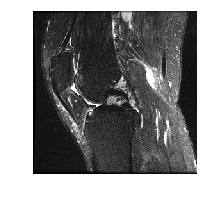

In [16]:
il[0].show()

In [17]:
sd = il.split_from_df(col=2)
sd

ItemLists;

Train: MRImageList (1130 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: ../data/sagittal;

Valid: MRImageList (120 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: ../data/sagittal;

Test: None

In [18]:
ll = sd.label_from_df(cols=1)
ll

LabelLists;

Train: LabelList (1130 items)
x: MRImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,1,1,1,1
Path: ../data/sagittal;

Valid: LabelList (120 items)
x: MRImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: ../data/sagittal;

Test: None

In [19]:
tfms = get_transforms()

In [20]:
bs = 8
data = ll.transform(tfms).databunch(bs=bs)

/home/walter/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


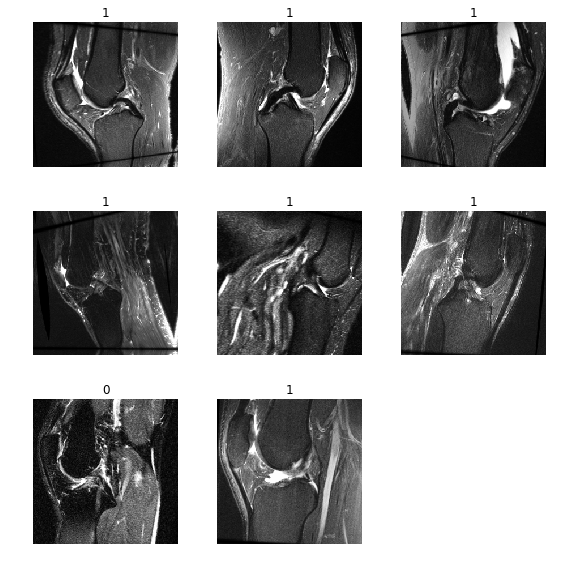

In [21]:
data.show_batch(rows=3, figsize=(8,8))

In [23]:
learn = cnn_learner(data, models.alexnet,
                    opt_func=optim.SGD,
                    loss_func=nn.CrossEntropyLoss(weight=weights),
                    metrics=accuracy)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/walter/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:19<00:00, 12253015.19it/s]


In [24]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 63, 63]         23,296     False     
______________________________________________________________________
ReLU                 [64, 63, 63]         0          False     
______________________________________________________________________
MaxPool2d            [64, 31, 31]         0          False     
______________________________________________________________________
Conv2d               [192, 31, 31]        307,392    False     
______________________________________________________________________
ReLU                 [192, 31, 31]        0          False     
______________________________________________________________________
MaxPool2d            [192, 15, 15]        0          False     
______________________________________________________________________
Conv2d               [384, 15, 15]        663,936    False     
______________________________________________________________

In [25]:
# learn.lr_find()

In [26]:
learn.recorder.plot()

AttributeError: 'Learner' object has no attribute 'recorder'

In [ ]:
# learn.fit_one_cycle(5, 1e-01)

In [ ]:
# learn.save('sag-stg-1')

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(5, slice(1e-05, 1e-04))